In [1]:
#import libraries to support processing and analyzing the data
import pandas as pd
import numpy as np
import statsmodels.api as sm
import math
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.preprocessing import PolynomialFeatures

In [2]:
#update set option for max rows to see more data
pd.set_option('display.max_rows', 100)

In [3]:
#read the training,test data into a pandas dataframe
train_data_frame = pd.read_csv('train.csv')
test_data_frame = pd.read_csv('test.csv')

In [4]:
#look at the training data to determine na counts for any potential features missing a lot of data
train_data_frame.isna().sum()

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

In [5]:
#determine the number of int/float features and categorical features
train_data_frame.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

In [6]:
#drop features with large number of nans from the dataframes
#drop Id feature from the dataframes
train_data_frame = train_data_frame.drop(columns = ["Alley","FireplaceQu","PoolQC","Fence","MiscFeature","Id"])
test_data_frame = test_data_frame.drop(columns = ["Alley","FireplaceQu","PoolQC","Fence","MiscFeature","Id"])

In [7]:
#split the dataframes into categorical features and not, in order to encode only the categorial features
train_ready_cols_df = train_data_frame.select_dtypes(exclude = 'object')
train_to_cleanse_cols_df = train_data_frame.select_dtypes(include = 'object')
test_ready_cols_df = test_data_frame.select_dtypes(exclude = 'object')
test_to_cleanse_cols_df = test_data_frame.select_dtypes(include = 'object')

In [8]:
### 1b. categorical features
train_to_cleanse_cols_df.columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'],
      dtype='object')

In [9]:
###CLEANSE AND ENCODE DATA

In [10]:
#for all features in the feature dataframes, use lambda to update types to category so they can be enconded
train_to_cleanse_cols_df = train_to_cleanse_cols_df.apply(lambda x: x.astype('category'))
test_to_cleanse_cols_df = test_to_cleanse_cols_df.apply(lambda x: x.astype('category'))

In [11]:
#encode the category features
train_to_cleanse_cols_df = train_to_cleanse_cols_df.apply(lambda x: x.astype('category').cat.codes)
test_to_cleanse_cols_df = test_to_cleanse_cols_df.apply(lambda x: x.astype('category').cat.codes)

In [12]:
#encoding nans will result in a -1 value, so we will go back into the dataframes and replace the -1s with nans
train_to_cleanse_cols_df = train_to_cleanse_cols_df.replace(-1,np.nan)
test_to_cleanse_cols_df = test_to_cleanse_cols_df.replace(-1,np.nan)

In [13]:
#for all nans in the categorically encoded features, fill them with the median values for each feature
train_to_cleanse_cols_df = train_to_cleanse_cols_df.fillna(train_to_cleanse_cols_df.median())
test_to_cleanse_cols_df = test_to_cleanse_cols_df.fillna(test_to_cleanse_cols_df.median())

In [14]:
#fill nans for all numeric features with the median values for each feature
train_ready_cols_df = train_ready_cols_df.fillna(train_ready_cols_df.median())
test_ready_cols_df = test_ready_cols_df.fillna(test_ready_cols_df.median())

In [15]:
#bring back the categorical and numeric feature dataframes into one cleansed data frame with concat
cleansed_training_df = pd.concat([train_ready_cols_df,train_to_cleanse_cols_df], axis = 1)
cleansed_test_df = pd.concat([test_ready_cols_df,test_to_cleanse_cols_df], axis = 1)

In [16]:
###CREATE X AND Y DATAFRAMES FOR PREDICTOR VARIABLES AND RESPONSE VARIABLE

In [17]:
X = cleansed_training_df.drop(columns = ['SalePrice'])
Y = cleansed_training_df['SalePrice']

In [18]:
### 1c. Correlations and Scatter Matrix

In [19]:
#determine the correlations between each feature and SalePrice
correlations = X.corrwith(Y)
correlations.sort_values()

ExterQual       -0.636884
BsmtQual        -0.594945
KitchenQual     -0.589189
GarageFinish    -0.482754
HeatingQC       -0.400178
GarageType      -0.302105
BsmtExposure    -0.295407
LotShape        -0.255580
MSZoning        -0.166872
KitchenAbvGr    -0.135907
EnclosedPorch   -0.128578
Heating         -0.098812
BldgType        -0.085591
MSSubClass      -0.084284
OverallCond     -0.077856
LotConfig       -0.067396
SaleType        -0.054911
BsmtFinType1    -0.053794
YrSold          -0.028923
LowQualFinSF    -0.025606
MiscVal         -0.021190
BsmtHalfBath    -0.016844
Utilities       -0.014314
BsmtFinSF2      -0.011378
Condition2       0.007513
LandContour      0.015453
MasVnrType       0.018216
BsmtFinType2     0.033235
Street           0.041036
3SsnPorch        0.044584
MoSold           0.046432
LandSlope        0.051152
BsmtCond         0.052563
Condition1       0.091155
PoolArea         0.092404
GarageQual       0.098759
Exterior1st      0.103551
Exterior2nd      0.103766
ScreenPorch 

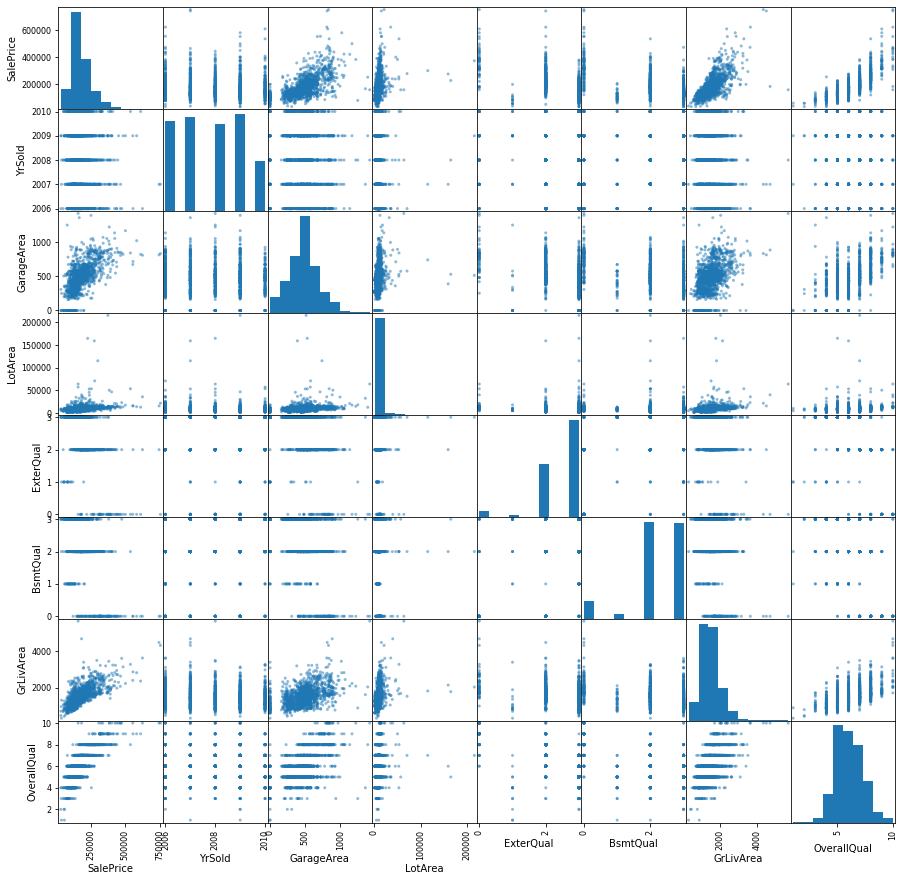

In [20]:
#create a subset of the X dataframe with features mentioned and those with high magnitude correlation
scatter_frame = cleansed_training_df[["SalePrice","YrSold","GarageArea","LotArea","ExterQual","BsmtQual","GrLivArea","OverallQual"]]

#plot the Scatter Matrix
scatter_ret = pd.plotting.scatter_matrix(scatter_frame, figsize=(15,15))

In [21]:
### PART 1E. TEST WITH DIFFERENT REGRESSION METHODS

In [22]:
#split the data 80/20 for train/test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [23]:
#Kaggle is using Root Mean Squared Logarithmic Error to evaluate the model's results, however there is no RMSLE in sklearn
#Therefore, we searched on Kaggle Forum and found an implementation of RMSLE which we borrowed below
#link = https://www.kaggle.com/jpopham91/rmlse-vectorized
def rmsle(y, y0):
    assert len(y) == len(y0)
    return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y0), 2)))

In [24]:
###OLS

In [25]:
ols_model = sm.OLS(Y_train,X_train)
ols_model_fit = ols_model.fit()
Y_pred = ols_model_fit.predict(X_test)

In [26]:
print("OLS Results:")
print("\tMean Squared Error = %0.3f" % (mean_squared_error(Y_test, Y_pred)))
print("\tMean Squared Log Error = %0.3f" % (mean_squared_log_error(Y_test, Y_pred)))
print("\tRoot Mean Squared Error = %0.3f" % (math.sqrt(mean_squared_error(Y_test, Y_pred))))
print("\tR-squared = %0.3f" % (r2_score(Y_test, Y_pred)))
print("\tRMSLE = %0.3f" % (rmsle(Y_test, Y_pred)))

OLS Results:
	Mean Squared Error = 1172057117.980
	Mean Squared Log Error = 0.037
	Root Mean Squared Error = 34235.320
	R-squared = 0.847
	RMSLE = 0.191


In [27]:
###KNN

In [28]:
#create an array to store the average mean_square_error for each k tested with cv = 10
mean_squared_error_array = []
kf = KFold(n_splits=10)

In [29]:
#test different k's from 1 - 100 with cv=10 and append the average scores for each k to mean_squared_error_array
for i in range(1,100):
    knn = KNeighborsClassifier(n_neighbors=i)
    scores = cross_val_score(knn, X_train, Y_train, cv=kf, scoring='neg_mean_squared_error')
    mean_squared_error_array.append(scores.mean())  

In [30]:
#convert the list to a numpy array, and then find the argmax of the neg_mean_squared_errors to find the optimal k
mean_squared_error_np = np.array(mean_squared_error_array)
optimal_k_index = np.argmax(mean_squared_error_np)
optimal_k_val = optimal_k_index+1

In [31]:
#once we find the optimal k, train the knn classifier with optimal k, and predict SalePrice for X_test
knn_train = KNeighborsClassifier(n_neighbors=optimal_k_val)
knn_train.fit(X_train,Y_train)
Y_pred_knn = knn_train.predict(X_test)

In [32]:
#print results
print("KNN Results:")
print("\tMean Squared Error = %0.3f" % (mean_squared_error(Y_test, Y_pred_knn)))
print("\tMean Squared Log Error = %0.3f" % (mean_squared_log_error(Y_test, Y_pred_knn)))
print("\tRoot Mean Squared Error = %0.3f" % (math.sqrt(mean_squared_error(Y_test, Y_pred_knn))))
print("\tR-squared = %0.3f" % (r2_score(Y_test, Y_pred_knn)))
print("\tRMSLE = %0.3f" % (rmsle(Y_test, Y_pred_knn)))

KNN Results:
	Mean Squared Error = 3615886071.808
	Mean Squared Log Error = 0.082
	Root Mean Squared Error = 60132.238
	R-squared = 0.529
	RMSLE = 0.287


In [33]:
###FORWARD STEPWISE

In [ ]:
#create a linear regression object
linear_regression = LinearRegression()

#call the SequentialFeatureSelector for forward stepwise, provide a min and max # of features from 1 to all and fit the model
forward_stepwise = SFS(linear_regression, k_features=(1,X_train.shape[1]), forward=True, floating=False, 
           verbose=2,scoring='neg_mean_squared_error',cv=10)
forward_stepwise = forward_stepwise.fit(X_train, Y_train, custom_feature_names =X_train.columns)

In [35]:
#once the SFS model has determined which features to keep, transform X_train and test to only include those features 
X_train_forward_stepwise = forward_stepwise.transform(X_train)
X_test_forward_stepwise = forward_stepwise.transform(X_test)

#use linear regression to fit the new feature set and predict SalePrice
linear_regression.fit(X_train_forward_stepwise, Y_train)
Y_pred_forward_stepwise = linear_regression.predict(X_test_forward_stepwise)

In [36]:
#print results
print("Forward Stepwise Results:")
print("\tMean Squared Error = %0.3f" % (mean_squared_error(Y_test, Y_pred_forward_stepwise)))
print("\tMean Squared Log Error = %0.3f" % (mean_squared_log_error(Y_test, Y_pred_forward_stepwise)))
print("\tRoot Mean Squared Error = %0.3f" % (math.sqrt(mean_squared_error(Y_test, Y_pred_forward_stepwise))))
print("\tR-squared = %0.3f" % (r2_score(Y_test, Y_pred_forward_stepwise)))
print("\tRMSLE = %0.3f" % (rmsle(Y_test, Y_pred_forward_stepwise)))

Forward Stepwise Results:
	Mean Squared Error = 1255421003.432
	Mean Squared Log Error = 0.035
	Root Mean Squared Error = 35431.921
	R-squared = 0.836
	RMSLE = 0.186


In [37]:
###BACKWARD STEPWISE

In [ ]:
#call the SequentialFeatureSelector for backward stepwise, provide a min and max # of features from 1 to all and fit the model
backward_stepwise = SFS(linear_regression, k_features=(1,X_train.shape[1]), forward=False, floating=False, 
           verbose=2,scoring='neg_mean_squared_error',cv=10)
backward_stepwise = backward_stepwise.fit(X_train, Y_train, custom_feature_names =X_train.columns)

#once the SFS model has determined which features to keep, transform X_train and test to only include those features 
X_train_backward_stepwise = backward_stepwise.transform(X_train)
X_test_backward_stepwise = backward_stepwise.transform(X_test)

#use linear regression to fit the new feature set and predict SalePrice
linear_regression.fit(X_train_backward_stepwise, Y_train)
Y_pred_backward_stepwise = linear_regression.predict(X_test_backward_stepwise)

In [39]:
#print results
print("Backward Stepwise Results:")
print("\tMean Squared Error = %0.3f" % (mean_squared_error(Y_test, Y_pred_backward_stepwise)))
print("\tMean Squared Log Error = %0.3f" % (mean_squared_log_error(Y_test, Y_pred_backward_stepwise)))
print("\tRoot Mean Squared Error = %0.3f" % (math.sqrt(mean_squared_error(Y_test, Y_pred_backward_stepwise))))
print("\tR-squared = %0.3f" % (r2_score(Y_test, Y_pred_backward_stepwise)))
print("\tRMSLE = %0.3f" % (rmsle(Y_test, Y_pred_backward_stepwise)))

Backward Stepwise Results:
	Mean Squared Error = 1309532376.508
	Mean Squared Log Error = 0.039
	Root Mean Squared Error = 36187.462
	R-squared = 0.829
	RMSLE = 0.198


In [40]:
#as the assignment instructions note, we need to standardize our data first and we do so using preprocessing.StandardScaler
X_train_scaled = preprocessing.StandardScaler().fit_transform(X_train)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_test_scaled = preprocessing.StandardScaler().fit_transform(X_test)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns = X_test.columns)

In [41]:
###RIDGE

In [42]:
alphas = 10**np.linspace(3,-4,200)
ridge_mse_array = []


for i in alphas:
    ridge_scores = cross_validate(linear_model.Ridge(alpha = i, max_iter = 10000), 
                                  X_train_scaled_df, Y_train, cv=10,scoring=('neg_mean_squared_error'))
    
    ridge_mse_array.append(ridge_scores['test_score'].mean())

In [43]:
ridge_mse_np = np.array(ridge_mse_array)
ridge_optimal_a_index = np.argmax(ridge_mse_np)
ridge_optimal_a_val = ridge_mse_np[ridge_optimal_a_index]
optimal_ridge_alpha = alphas[ridge_optimal_a_index]

In [44]:
ridge_train = linear_model.Ridge(alpha = optimal_ridge_alpha, max_iter = 100000)
ridge_train.fit(X_train_scaled_df,Y_train)
Y_pred_ridge = ridge_train.predict(X_test_scaled_df)

In [45]:
#print results
print("Ridge Results:")
print("\tMean Squared Error = %0.3f" % (mean_squared_error(Y_test, Y_pred_ridge)))
print("\tMean Squared Log Error = %0.3f" % (mean_squared_log_error(Y_test, Y_pred_ridge)))
print("\tRoot Mean Squared Error = %0.3f" % (math.sqrt(mean_squared_error(Y_test, Y_pred_ridge))))
print("\tR-squared = %0.3f" % (r2_score(Y_test, Y_pred_ridge)))
print("\tRMSLE = %0.3f" % (rmsle(Y_test, Y_pred_ridge)))

Ridge Results:
	Mean Squared Error = 1228755525.821
	Mean Squared Log Error = 0.027
	Root Mean Squared Error = 35053.609
	R-squared = 0.840
	RMSLE = 0.164


In [46]:
###LASSO

In [47]:
lasso_mse_array = []


for i in alphas:
    lasso_scores = cross_validate(linear_model.Lasso(alpha = i, max_iter = 100000), 
                                  X_train_scaled_df, Y_train, cv=10,scoring=('neg_mean_squared_error'))
    
    lasso_mse_array.append(lasso_scores['test_score'].mean())

In [48]:
lasso_mse_np = np.array(lasso_mse_array)
lasso_optimal_a_index = np.argmax(lasso_mse_np)
lasso_optimal_a_val = lasso_mse_np[lasso_optimal_a_index]
optimal_lasso_alpha = alphas[lasso_optimal_a_index]

In [49]:
lasso_train = linear_model.Lasso(alpha = optimal_lasso_alpha, max_iter = 100000)
lasso_train.fit(X_train_scaled_df,Y_train)
Y_pred_lasso = lasso_train.predict(X_test_scaled_df)

In [50]:
#print results
print("Lasso Results:")
print("\tMean Squared Error = %0.3f" % (mean_squared_error(Y_test, Y_pred_lasso)))
print("\tMean Squared Log Error = %0.3f" % (mean_squared_log_error(Y_test, Y_pred_lasso)))
print("\tRoot Mean Squared Error = %0.3f" % (math.sqrt(mean_squared_error(Y_test, Y_pred_lasso))))
print("\tR-squared = %0.3f" % (r2_score(Y_test, Y_pred_lasso)))
print("\tRMSLE = %0.3f" % (rmsle(Y_test, Y_pred_lasso)))

Lasso Results:
	Mean Squared Error = 1207618339.764
	Mean Squared Log Error = 0.030
	Root Mean Squared Error = 34750.803
	R-squared = 0.843
	RMSLE = 0.172


In [51]:
###1F. Quadratic Features

In [52]:
#use polynomial features to add quadratic features to the data
quadratic_features = PolynomialFeatures(2)
X_train_quadratic = quadratic_features.fit_transform(X_train)
X_test_quadratic = quadratic_features.fit_transform(X_test)

X_train_scaled_quadratic = quadratic_features.fit_transform(X_train_scaled_df)
X_test_scaled_quadratic = quadratic_features.fit_transform(X_test_scaled_df)

In [53]:
#create an array to store the average MSE for each k tested using cv = 10 folds
knn_quadratic_features_mse_array = []
kf = KFold(n_splits=10)

In [54]:
#test with k nearest neighbors from 1 to 50 to find optimal k
for i in range(1,50):
    knn = KNeighborsClassifier(n_neighbors=i)
    scores = cross_val_score(knn, X_train_quadratic, Y_train, cv=kf, scoring='neg_mean_squared_error')
    knn_quadratic_features_mse_array.append(scores.mean())

In [55]:
#find the optimal k, and then run knn with that k and fit the data. Then predict values using X_test_quadratic
knn_mse_quadratic_np = np.array(knn_quadratic_features_mse_array)
quadratic_optimal_k_index = np.argmax(knn_mse_quadratic_np)
quadratic_optimal_k_val = quadratic_optimal_k_index+1

knn_train_quadratic = KNeighborsClassifier(n_neighbors=quadratic_optimal_k_val)
knn_train_quadratic.fit(X_train_quadratic,Y_train)
Y_pred_knn_quadratic = knn_train_quadratic.predict(X_test_quadratic)

In [56]:
#print results
print("KNN Quadratic Results:")
print("\tMean Squared Error = %0.3f" % (mean_squared_error(Y_test, Y_pred_knn_quadratic)))
print("\tMean Squared Log Error = %0.3f" % (mean_squared_log_error(Y_test, Y_pred_knn_quadratic)))
print("\tRoot Mean Squared Error = %0.3f" % (math.sqrt(mean_squared_error(Y_test, Y_pred_knn_quadratic))))
print("\tR-squared = %0.3f" % (r2_score(Y_test, Y_pred_knn_quadratic)))
print("\tRMSLE = %0.3f" % (rmsle(Y_test, Y_pred_knn_quadratic)))

KNN Quadratic Results:
	Mean Squared Error = 2901376149.062
	Mean Squared Log Error = 0.071
	Root Mean Squared Error = 53864.424
	R-squared = 0.622
	RMSLE = 0.266


In [57]:
###RIDGE

In [58]:
alphas = 10**np.linspace(3,-4,30)

In [59]:
#create an array to store the mean MSE for each alpha tested 
ridge_quadratic_mse_array = []


for i in alphas:
    ridge_quadratic_scores = cross_validate(linear_model.Ridge(alpha = i, max_iter = 10000, tol = .01), 
                                  X_train_scaled_quadratic, Y_train, cv=10,scoring=('neg_mean_squared_error'))
    
    ridge_quadratic_mse_array.append(ridge_quadratic_scores['test_score'].mean())  

In [60]:
#find the optimal alpha
ridge_quadratic_mse_np = np.array(ridge_quadratic_mse_array)
ridge_quadratic_optimal_a_index = np.argmax(ridge_quadratic_mse_np)
ridge_quadratic_optimal_a_val = ridge_quadratic_mse_np[ridge_quadratic_optimal_a_index]
optimal_quadratic_ridge_alpha = alphas[ridge_quadratic_optimal_a_index]

In [61]:
#fit the data with the optimal alpha, and predict X
ridge_quadratic_train = linear_model.Ridge(alpha = optimal_quadratic_ridge_alpha, max_iter = 10000, tol = .01)
ridge_quadratic_train.fit(X_train_scaled_quadratic,Y_train)
Y_pred_ridge_quadratic = ridge_quadratic_train.predict(X_test_scaled_quadratic)

In [62]:
#print results
print("Ridge Quadratic Results:")
print("\tMean Squared Error = %0.3f" % (mean_squared_error(Y_test, Y_pred_ridge_quadratic)))
print("\tMean Squared Log Error = %0.3f" % (mean_squared_log_error(Y_test, Y_pred_ridge_quadratic)))
print("\tRoot Mean Squared Error = %0.3f" % (math.sqrt(mean_squared_error(Y_test, Y_pred_ridge_quadratic))))
print("\tR-squared = %0.3f" % (r2_score(Y_test, Y_pred_ridge_quadratic)))
print("\tRMSLE = %0.3f" % (rmsle(Y_test, Y_pred_ridge_quadratic)))

Ridge Quadratic Results:
	Mean Squared Error = 1077707336.575
	Mean Squared Log Error = 0.049
	Root Mean Squared Error = 32828.453
	R-squared = 0.859
	RMSLE = 0.221


In [63]:
###LASSO

In [64]:
#create an array to store the mean MSE for each alpha tested 
lasso_quadratic_mse_array = []


for i in alphas:
    lasso_quadratic_scores = cross_validate(linear_model.Lasso(alpha = i, max_iter = 10000, tol = .01), 
                                  X_train_scaled_quadratic, Y_train, cv=10,scoring=('neg_mean_squared_error'))
    
    lasso_quadratic_mse_array.append(lasso_quadratic_scores['test_score'].mean())

In [65]:
#find the optimal alpha
lasso_quadratic_mse_np = np.array(lasso_quadratic_mse_array)
lasso_quadratic_optimal_a_index = np.argmax(lasso_quadratic_mse_np)
lasso_quadratic_optimal_a_val = lasso_quadratic_mse_np[lasso_quadratic_optimal_a_index]
optimal_quadratic_lasso_alpha = alphas[lasso_quadratic_optimal_a_index]

In [66]:
#fit the data with the optimal alpha, and predict X
lasso_quadratic_train = linear_model.Lasso(alpha = optimal_quadratic_lasso_alpha, max_iter = 10000, tol = .01)
lasso_quadratic_train.fit(X_train_scaled_quadratic,Y_train)
Y_pred_lasso_quadratic = lasso_quadratic_train.predict(X_test_scaled_quadratic)

In [67]:
#print results
print("Lasso Quadratic Results:")
print("\tMean Squared Error = %0.3f" % (mean_squared_error(Y_test, Y_pred_lasso_quadratic)))
print("\tMean Squared Log Error = %0.3f" % (mean_squared_log_error(Y_test, Y_pred_lasso_quadratic)))
print("\tRoot Mean Squared Error = %0.3f" % (math.sqrt(mean_squared_error(Y_test, Y_pred_lasso_quadratic))))
print("\tR-squared = %0.3f" % (r2_score(Y_test, Y_pred_lasso_quadratic)))
print("\tRMSLE = %0.3f" % (rmsle(Y_test, Y_pred_lasso_quadratic)))

Lasso Quadratic Results:
	Mean Squared Error = 830155522.467
	Mean Squared Log Error = 0.052
	Root Mean Squared Error = 28812.420
	R-squared = 0.892
	RMSLE = 0.228


In [68]:
### 1G

In [69]:
#print the retained features for forward stepwise
print('Retained features for forward stepwise: \n')
print(forward_stepwise.k_feature_names_)

Retained features for forward stepwise: 

('MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'MasVnrArea', 'GrLivArea', 'BsmtFullBath', 'Fireplaces', 'GarageCars', 'WoodDeckSF', '3SsnPorch', 'ScreenPorch', 'LandSlope', 'Neighborhood', 'RoofStyle', 'Exterior1st', 'MasVnrType', 'ExterQual', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'CentralAir', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'PavedDrive')


In [71]:
#print the retained features for forward stepwise
print('Retained features for backward stepwise: \n')
print(backward_stepwise.k_feature_names_)

Retained features for backward stepwise: 

('MSSubClass', 'LotFrontage', 'OverallQual', 'OverallCond', 'MasVnrArea', 'GrLivArea', 'BsmtFullBath', 'Fireplaces', 'GarageCars', '3SsnPorch', 'LotShape', 'LandContour', 'LandSlope', 'Neighborhood', 'RoofStyle', 'MasVnrType', 'ExterQual', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'PavedDrive')


In [72]:
#create two arrays for which coefficients are retained and regularized away for lasso based on coef_
#regularized away are those that equal 0
lasso_retained = []
lasso_regularized_away = []

for i in range(len(lasso_train.coef_)):
    if lasso_train.coef_[i] == 0:
        lasso_regularized_away.append(X.columns[i])
    else:
        lasso_retained.append(X.columns[i])

In [74]:
#print lasso retained and regularized away features
print('Lasso retained features:\n')
print(lasso_retained)
print('\nLasso regularized away features:\n')
print(lasso_regularized_away)

Lasso retained features:

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'WoodDeckSF', '3SsnPorch', 'ScreenPorch', 'MSZoning', 'LotShape', 'LandContour', 'Utilities', 'LandSlope', 'Neighborhood', 'Condition2', 'BldgType', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'MasVnrType', 'ExterQual', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageCond', 'PavedDrive', 'SaleCondition']

Lasso regularized away features:

['BsmtFinSF2', 'BsmtUnfSF', '2ndFlrSF', 'LowQualFinSF', 'BsmtHalfBath', 'HalfBath', 'BedroomAbvGr', 'GarageYrBlt', 'GarageArea', 'OpenPorchSF', 'EnclosedPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'Street', 'LotConfig', 'Condition1', 'HouseStyle', 'Exterior2nd', 'ExterCond

In [75]:
###1H

In [76]:
#Final Submission of Ridge as top performer
#standardize full X for training and the test data using preprocessing.StandardScaler
X_scaled = preprocessing.StandardScaler().fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns = X.columns)

X_to_test_scaled = preprocessing.StandardScaler().fit_transform(cleansed_test_df)
X_to_test_scaled_df = pd.DataFrame(X_to_test_scaled, columns = X.columns)

In [77]:
#create an array to store the mean MSE for each alpha tested for final ridge submission on entire training set
ridge_final_mse_array = []

for i in alphas:
    ridge_final_scores = cross_validate(linear_model.Ridge(alpha = i, max_iter = 10000, tol = .01), 
                                  X_scaled_df, Y, cv=10,scoring=('neg_mean_squared_error'))
    
    ridge_final_mse_array.append(ridge_final_scores['test_score'].mean())  

In [78]:
#find the optimal alpha
ridge_final_mse_np = np.array(ridge_final_mse_array)
ridge_final_optimal_a_index = np.argmax(ridge_final_mse_np)
ridge_final_optimal_a_val = ridge_final_mse_np[ridge_final_optimal_a_index]
optimal_final_ridge_alpha = alphas[ridge_final_optimal_a_index]

In [79]:
#fit the model with the optimal alpha for ridge
ridge_final = linear_model.Ridge(alpha = optimal_final_ridge_alpha, max_iter = 100000, tol = .01)
ridge_final.fit(X_scaled_df,Y)
Y_pred_ridge_final = ridge_final.predict(X_to_test_scaled_df)

In [81]:
#create a dataframe for the submission output
kaggle_upload_df = pd.DataFrame(Y_pred_ridge_final, columns = ['SalePrice'])
kaggle_upload_df['Id'] = kaggle_upload_df.index + 1461
kaggle_upload_df = kaggle_upload_df[['Id', 'SalePrice']]

In [82]:
#create output csv to upload to kaggle
kaggle_upload_df.to_csv(r'House_prices_3.csv', index = None, header=True)